In [1]:
import os, re
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NVIDIA GeForce RTX 3060


In [3]:
filenames = os.listdir('datasets')
num_resolutions = []
timebuckets = []
pattern_train = re.compile(r'train_dataset_res_(\d+)_bucket_(\d+)\.pt')
pattern_valid = re.compile(r'valid_dataset_res_(\d+)_bucket_(\d+)\.pt')
for filename in filenames:
    match_train = pattern_train.match(filename)
    match_valid = pattern_valid.match(filename)
    if match_train:
        X, Y = map(int, match_train.groups())
        if (X - 6) not in num_resolutions:
            num_resolutions.append(X - 6)
        if Y not in timebuckets:
            timebuckets.append(Y)
    if match_valid:
        X, Y = map(int, match_valid.groups())
        if (X - 6) not in num_resolutions:
            num_resolutions.append(X - 6)
        if Y not in timebuckets:
            timebuckets.append(Y)

num_resolutions = len(num_resolutions)
timebuckets = sorted(timebuckets)
train_dl = [[None for _ in range(len(timebuckets))] for _ in range(num_resolutions)]
val_dl = [[None for _ in range(len(timebuckets))] for _ in range(num_resolutions)]
for i in range(num_resolutions):
    for j in range(len(timebuckets)):
        train_dl[i][j] = DataLoader(
            torch.load(f'datasets/train_dataset_res_{i + 6}_bucket_{timebuckets[j]}.pt', weights_only = False),
            batch_size = 128,
            shuffle = True
        )
        val_dl[i][j] = DataLoader(
            torch.load(f'datasets/valid_dataset_res_{i + 6}_bucket_{timebuckets[j]}.pt', weights_only = False),
            batch_size = 128,
            shuffle = False
        )

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x

In [5]:
def train(model, train_dl, val_dl, loss_fn, optimizer, num_epochs, i, j, timebuckets, device):
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_dl:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_dl.dataset)
        train_losses.append(train_loss)
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_dl:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                valid_loss += loss.item() * X_batch.size(0)
        
        valid_loss /= len(val_dl.dataset)
        valid_losses.append(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'trained_models/nn_model_res_{i + 6}_bucket_{timebuckets[j]}.pth')
    return train_losses, valid_losses

In [6]:
train_losses = [[None for _ in range(len(timebuckets))] for _ in range(num_resolutions)]
valid_losses = [[None for _ in range(len(timebuckets))] for _ in range(num_resolutions)]
for i in tqdm(range(num_resolutions), desc = f'Resolutions'):
    for j in tqdm(range(len(timebuckets)), desc = f'Timebuckets', leave=False):
        model = NeuralNetwork(23).to(device)
        loss_fn = nn.MSELoss().to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
        train_losses[i][j], valid_losses[i][j] = train(model, train_dl[i][j], val_dl[i][j], loss_fn, optimizer, 50, i, j, timebuckets, device)

Resolutions:   0%|          | 0/3 [00:00<?, ?it/s]

Timebuckets:   0%|          | 0/5 [00:00<?, ?it/s]

Timebuckets:   0%|          | 0/5 [00:00<?, ?it/s]

Timebuckets:   0%|          | 0/5 [00:00<?, ?it/s]

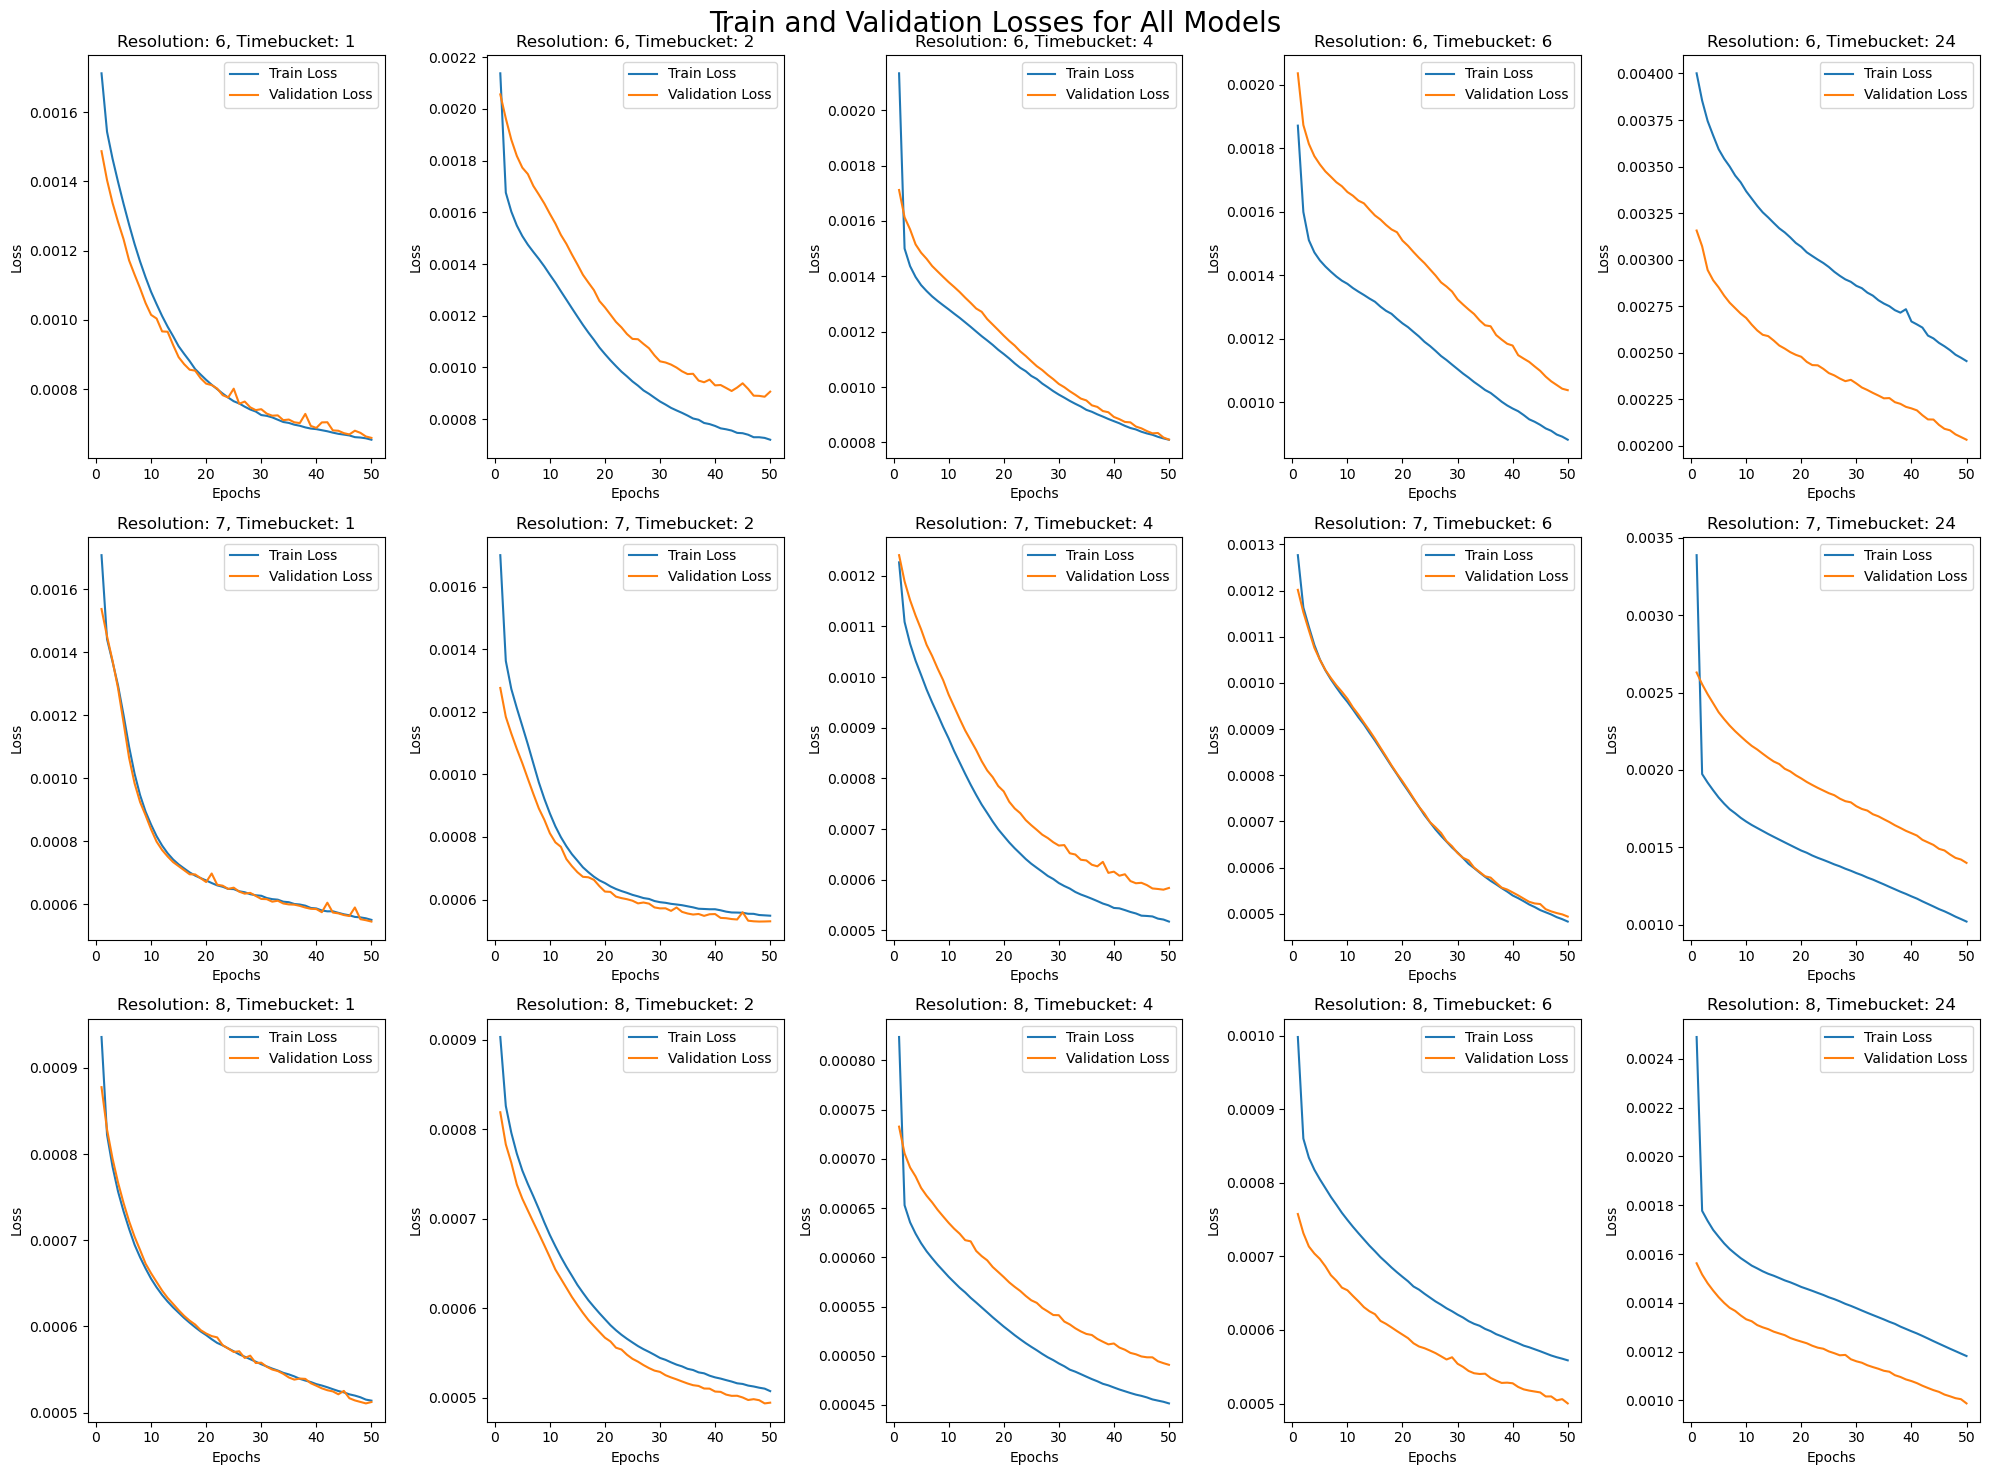

In [7]:
fig, axs = plt.subplots(num_resolutions, len(timebuckets), figsize=(20, 15))
fig.suptitle('Train and Validation Losses for All Models', size = 20)
for row in range(num_resolutions):
    for col in range(len(timebuckets)):
        ax = axs[row, col]
        ax.plot(range(1, len(train_losses[row][col]) + 1), train_losses[row][col], label='Train Loss')
        ax.plot(range(1, len(valid_losses[row][col]) + 1), valid_losses[row][col], label='Validation Loss')
        ax.set_title(f'Resolution: {row + 6}, Timebucket: {timebuckets[col]}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('images/train_and_validation_losses.png', dpi = 600)
plt.show()